In [406]:
import os
import re
import pandas as pd
from time import time
import datetime
import numpy as np
import spacy
import nltk
import wrds
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import tqdm


In [407]:
RANDOM_SEED = 7
DATA_DIR = "../data/"

# note: wsb=wallstreetbets
wsb_data_path = os.path.join(DATA_DIR, 'wsb_comments/wsb_comments_raw.csv')
stock_data_path = os.path.join(DATA_DIR, 'GME')

db = wrds.Connection(wrds_username='debabech', wrds_passeword='Electro1004$')
db.create_pgpass_file()
permcos = db.get_table(library='crsp', table='stocknames')[
    ["permco", "ticker"]]

# efficiency and accuracy --> "en_core_web_trf"
nlp = spacy.load("en_core_web_sm")


Loading library list...
Done


In [408]:
def load_wsb_data(data_path, nrows=None):
    "Load wsb data, nrows None indicates all rows, otherwise specified integer of rows"
    return pd.read_csv(wsb_data_path, nrows=nrows, delimiter=',')


def load_stock_wrds(ticker):
    permco = permcos[permcos.ticker == ticker].permco.values[0]
    # to 2021-03-25 ??
    req = f"select prc, date from crsp.dsf where permco in ({permco}) and date >='2012-01-31' and date <='2021-02-16'"
    asset = db.raw_sql(req, date_cols=['date'])
    asset = asset.dropna()
    asset["log_ret"] = np.log(asset.prc).diff(1)

    return asset["log_ret"]


def load_stock_yh(ticker):
    asset = yf.download(ticker, interval='1d',
                        start="2012-01-31", end="2021-02-16")
    asset = asset.dropna()
    asset["log_ret"] = np.log(asset.Close - asset.Open) #np.log(asset.Open).diff(1).shift(-1)

    return asset["log_ret"]


In [447]:
wsb_df = load_wsb_data(wsb_data_path, nrows=10_000)
wsb_df['raw'] = wsb_df['body']


In [448]:
SPY = load_stock_yh('SPY')
DJI = load_stock_yh('DJI')
NDAQ = load_stock_yh('NDAQ')
INX = load_stock_yh('INX')
NDXE = load_stock_yh('^NDXE')
OEX = load_stock_yh('OEX')

df_tickers = pd.concat([SPY, DJI, NDAQ, INX, NDXE, OEX], axis=1)
df_tickers.columns = ['SPY', 'DJI', 'NDAQ', 'INX', 'NDXE', 'OEX']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [449]:

class PreProcessing:

    def __init__(self, wsb_data, lemmatize=True, lower_case=True, rem_stopwords=True, rem_punctuation=True, tokenize=True):
        """
        Initialise all class parameters

        :param data: nonempty pandas dataframe, wsb dataframe 
        :param lemmatize: bool, whether to perform lemmatization
        :param lower_case: bool, whether to lowercase
        :param rem_stopwords: bool, whether to remove stopwords
        :param tokenize: bool, whether to tokenize
        """

        self.wsb_data = wsb_data
        self.lemmatize = lemmatize
        self.lower_case = lower_case
        self.rem_stopwords = rem_stopwords
        self.rem_punctuation = rem_punctuation
        self.tokenize = tokenize

    # Ensure Parameter types
    # K: need to add to this one gradually as we add columns that we use etc.
    @property
    def wsb_data(self):
        return self._wsb_data

    @wsb_data.setter
    def wsb_data(self, wsb_data):

        req_columns = ['author', 'body', 'created_utc']
        str_columns = ['body']
        date_columns = ['created_utc']

        # Ensure the provided object is a dataframe
        if not isinstance(wsb_data, pd.DataFrame):
            raise Exception("The provided data must be a pandas Dataframe")

        # Ensure wsb dataframe is non empty
        if wsb_data.shape[0] == 0:
            raise Exception("Provided Dataframe is empty")

        # Ensure all required columns are provided
        missing_columns = set(req_columns).difference(
            set(wsb_data.columns.tolist()))
        if len(missing_columns) > 0:
            raise Exception(
                f"The columns {missing_columns} are missing from the provided dataframe!")

        # Ensure all column names don't have unexpected periods
        if '.' in list(''.join(wsb_data.columns.tolist())):
            raise Exception("All Column names must not include periods :'.'")

        # Ensure all string columns are strings
        non_str_columns = set(str_columns).difference(
            set(wsb_data.select_dtypes(include='object')))
        if len(non_str_columns) > 0:
            raise Exception(
                f'The columns {non_str_columns} are expected as string (pandas object) columns.')

        # Ensure dates are interpretable
        for date_col in date_columns:
            pd.to_datetime(wsb_data[date_col], unit='s', errors='ignore')
            if pd.to_datetime(wsb_data[date_col], unit='s', errors='ignore').notnull().all():
                try:
                    # Otherwise Convert date using unixtimestamp to datetime object
                    wsb_data[date_col] = pd.to_datetime(
                        wsb_data[date_col], unit='s', errors='ignore')
                except:
                    raise Exception(
                        f"{date_col} must be a valid unixtimestamp format")

        self._wsb_data = wsb_data

    @property
    def lemmatize(self):
        return self._lemmatize

    @lemmatize.setter
    def lemmatize(self, lemmatize):
        if not isinstance(lemmatize, bool):
            raise Exception(
                'lemmatize must be provided as a boolean parameter (True/False) to the class')
        self._lemmatize = lemmatize

    @property
    def lower_case(self):
        return self._lower_case

    @lower_case.setter
    def lower_case(self, lower_case):
        if not isinstance(lower_case, bool):
            raise Exception(
                'lower_case must be provided as a boolean parameter (True/False) to the class')
        self._lower_case = lower_case

    @property
    def rem_stopwords(self):
        return self._rem_stopwords

    @rem_stopwords.setter
    def rem_stopwords(self, rem_stopwords):
        if not isinstance(rem_stopwords, bool):
            raise Exception(
                'rem_stopwords must be provided as a boolean parameter (True/False) to the class')
        self._rem_stopwords = rem_stopwords

    @property
    def rem_punctuation(self):
        return self._rem_punctuation

    @rem_punctuation.setter
    def rem_punctuation(self, rem_punctuation):
        if not isinstance(rem_punctuation, bool):
            raise Exception(
                'rem_punctuation must be provided as a boolean parameter (True/False) to the class')
        self._rem_punctuation = rem_punctuation

    @property
    def tokenize(self):
        return self._tokenize

    @tokenize.setter
    def tokenize(self, tokenize):
        if not isinstance(tokenize, bool):
            raise Exception(
                'tokenize must be provided as a boolean parameter (True/False) to the class')
        self._tokenize = tokenize

    def clean_textual_data(self, textual_columns):

        # Ensure the provided textual columns exist, and if single string column name convert it into a list
        if len(textual_columns) < 1:
            raise Exception(
                'The number of textual columns to clean must be greater than 0')
        if isinstance(textual_columns, str):
            textual_columns = [textual_columns]
        missing_columns = set(textual_columns).difference(
            set(self.wsb_data.columns.tolist()))
        if len(missing_columns) > 0:
            raise Exception(
                f"The columns {missing_columns} to clean are missing from the wsb dataframe!")

        def lower_case_fn(self, col_name):
            self.wsb_data[col_name] = self.wsb_data[col_name].str.lower()
            return self.wsb_data

        def lemmatize_fn(self, col_name):
            w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
            lemmatizer = nltk.stem.WordNetLemmatizer()
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])
            return self.wsb_data

        def stemming_fn(self, col_name):
            w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
            stemmer = nltk.stem.porter.PorterStemmer()
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [stemmer.stem(w) for w in w_tokenizer.tokenize(x)])
            return self.wsb_data

        def tokenize_fn(self, col_name):
            w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [w for w in w_tokenizer.tokenize(x)])
            return self.wsb_data

        def rem_punctuation_fn(self, col_name):
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [w for w in x if w.isalnum()])
            return self.wsb_data

        def rem_stopwords_fn(self, col_name):
            "stopwords dictionary considered English, wsb is an english forum"
            remove_elements = set(nltk.corpus.stopwords.words('english'))
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [w for w in x if not w in remove_elements])
            return self.wsb_data

        def remove_tokenization(self, col_name):
            "Necessary as final step to untokenize in case desired, tokenization required for other functions to not break"
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: ' '.join(x))
            return self.wsb_data

        for textual_col in textual_columns:

            if self.lower_case:
                lower_case_fn(self, textual_col)

            # lemmatize tokens if true, if false, stem tokens, if None then just tokenize
            if self.lemmatize:
                lemmatize_fn(self, textual_col)
            elif self.lemmatize:
                stemming_fn(self, textual_col)
            else:
                tokenize_fn(self, textual_col)

            if self.rem_punctuation:
                rem_punctuation_fn(self, textual_col)
            if self.rem_stopwords:
                rem_stopwords_fn(self, textual_col)
            if not self.tokenize:
                remove_tokenization(self, textual_col)

        return self.wsb_data

    # to later remove: for development

    def output_data(self):
        return self.wsb_data


In [450]:
WSBPreProcessing = PreProcessing(
    wsb_df, lemmatize=True, lower_case=True, rem_stopwords=True, rem_punctuation=True, tokenize=True)
WSBPreProcessing.clean_textual_data('body')
useful_columns = ['author', 'raw', 'body',
                  'created_utc', 'score', 'link_id', 'is_submitter']
WSB_preprocessed_data = WSBPreProcessing.output_data()[useful_columns]
WSB_preprocessed_data = WSB_preprocessed_data[WSB_preprocessed_data['author'] != '[deleted]']


In [451]:
def rem_url_at(df):
    raw = []
    for sentence in df['raw']:
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'
                          '(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', sentence)
        sentence = re.sub("(@[A-Za-z0-9_]+)", "", sentence)
        raw.append(sentence)
    df['raw'] = raw

    return df


def tagging(df):
    pos,tag,dep,shape = [],[],[],[]
    for sentence in df['raw']:
        pos_tmp,tag_tmp,dep_tmp,shape_tmp = [],[],[],[]
        for token in nlp(sentence):
            pos_tmp.append(token.pos_)
            tag_tmp.append(token.tag_)
            dep_tmp.append(token.dep_)
            shape_tmp.append(token.shape_)
        pos.append(pos_tmp)
        tag.append(tag_tmp)
        dep.append(dep_tmp)
        shape.append(shape_tmp)

    df['Pos'] = pos
    df['Tag'] = tag
    df['Dep'] = dep
    df['Shape'] = shape

    return df


In [452]:
WSB_preprocessed_data = rem_url_at(WSB_preprocessed_data)
WSB_preprocessed_data = tagging(WSB_preprocessed_data)

WSB_preprocessed_data.replace('', np.nan, inplace=True)
WSB_preprocessed_data = WSB_preprocessed_data.dropna(how='any', axis=0)
WSB_preprocessed_data = WSB_preprocessed_data[WSB_preprocessed_data['body'].map(
    lambda d: len(d)) > 0]


## Sentiment Analyser
- Flair
- Vader
- Blob

In [453]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')


2021-12-31 18:58:56,021 loading file /Users/ade/.flair/models/sentiment-en-mix-distillbert_4.pt


In [454]:
def sentiment_analyser(df, v=True, f=True, b=True, r_vader=0.8, r_fler=0.1, r_blob=0.1):

    df_fler, df_vader, df_blob = [], [], []
    for sentence in tqdm(df['raw']):
        if v:
            df_vader.append(vader(sentence))
        if f:
            df_fler.append(fler(sentence))
        if b:
            df_blob.append(blob(sentence))
    df['VADER'] = df_vader
    df['FLAIR'] = df_fler
    df['BLOB'] = df_blob

    if v and f and b:
        df['compound'] = df['VADER']*r_vader + \
            df['FLAIR']*r_fler + df['BLOB']*r_blob
    elif v and f and not b:
        df['compound'] = df['VADER']*(r_vader+r_blob) + df['FLAIR']*r_fler
    elif v and b and not f:
        df['compound'] = df['VADER']*(r_vader+r_fler) + df['BLOB']*r_blob
    else:
        df['compound'] = df['VADER']

    return df


def vader(sentence):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(sentence)['compound']
    return float(sentiment)


def fler(sentence):
    s = Sentence(sentence)
    classifier.predict(s)
    sentiment = str(s.labels[0])
    num = float(re.findall(r'\d+\.\d+', sentiment)[0])
    if sentiment.find('POSITIVE') == -1:
        num = num * -1
    return num


def blob(sentence):
    sentiment = TextBlob(sentence).sentiment.polarity
    return sentiment


WSB_preprocessed_data = sentiment_analyser(WSB_preprocessed_data)


### Fast Fourier Transform on Sentiment Analyses

In [455]:
from scipy.fftpack import fft, ifft


def fourier(df, n_dimensions):
    for n in n_dimensions:
        n = round(n)
        tmp_ = fft(df['compound'].values)
        tmp_[n:-n] = 0
        df['fourier_'+str(n)] = ifft(tmp_)
    return df


l = len(WSB_preprocessed_data)
WSB_preprocessed_data = fourier(
    WSB_preprocessed_data, np.linspace(round(l*0.1), round(l*0.9), 5))


In [535]:
def merged_df(df, df_tickers, column='compound', freq='D', var=1.1):
    final_df = pd.DataFrame()

    df['final_compound'] = df.score**var * df[column]
    final_df['final_compound'] = df.groupby(
        df['created_utc'].dt.to_period(freq)).final_compound.mean()
    final_df.index = final_df.index.to_timestamp()
    final_df = pd.merge(final_df, df_tickers, left_index=True, right_index=True)     # .dropna(subset=["final_compound"], inplace=True)

    return final_df

final_df = merged_df(WSB_preprocessed_data, df_tickers)


### Splitting and pickle files

(array([5., 8., 0., 2., 0., 1., 1., 0., 2., 1.]),
 array([0.        , 0.01714286, 0.03428571, 0.05142857, 0.06857143,
        0.08571429, 0.10285714, 0.12      , 0.13714286, 0.15428571,
        0.17142857]),
 <BarContainer object of 10 artists>)

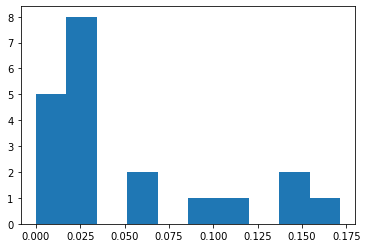

In [548]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(gap=0, max_train_size=0.8, n_splits=3, test_size=0.1)

X = final_df.final_compound
y = final_df.SPY #for SPY
# plt.hist(y.value_counts(normalize=True, bins=20))

for train_index, test_index in tscv.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



In [ ]:

for train_index, test_index in tscv.split(X):
print("TRAIN:", train_index, "TEST:", test_index)
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]